<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.1
IPython 5.3.0

numpy 1.13.3
scipy 0.19.0
pandas 0.20.1
matplotlib 2.1.0
statsmodels 0.8.0
sklearn 0.19.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ca8e6e4e47061a4c44a8506c9741b1c65fc9249a


In [170]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [171]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'C:\\Users\\VyaznikovKS\\Desktop\\_уч\\PY_spec\\1_prepare_data\\capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [172]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [173]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [174]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [175]:
type(y_train)

numpy.ndarray

In [176]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [108]:
def plot_validation_curves(param_values, grid_cv_results_):
    #train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    #train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    #plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
    #                 facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
''' ВАШ КОД ЗДЕСЬ '''
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [22]:
''' ВАШ КОД ЗДЕСЬ '''
cross_val_score(knn, X_train.todense(), y_train, cv=skf)

array([0.56629077, 0.55562329, 0.56310976])

In [23]:
accuracy_score(y_valid, knn.fit(X_train.todense(), y_train).predict(X_valid.todense()))

0.5894761791893813

In [27]:
sum([0.56629077, 0.55562329, 0.56310976])/3

0.5616746066666667

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
''' ВАШ КОД ЗДЕСЬ '''
forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=17) 

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [31]:
%%time
forest.fit(X_train.todense(), y_train)

Wall time: 16.3 s


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=17)

In [34]:
forest.oob_score_

0.7217029059134322

In [35]:
accuracy_score(y_valid, forest.predict(X_valid.todense()))

0.7257643991467172

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [177]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [37]:
''' ВАШ КОД ЗДЕСЬ '''
logit = LogisticRegression(n_jobs=-1, random_state=17)

In [38]:
cross_val_score(logit, X_train.todense(), y_train, cv=skf).mean()

0.7606189739891912

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [39]:
%%time
''' ВАШ КОД ЗДЕСЬ ''' 

logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(logit_c_values1, cv = skf, multi_class='multinomial', n_jobs=-1, random_state=17) 
logit_grid_searcher1.fit(X_train.todense(), y_train)

Wall time: 2min 8s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [79]:
''' ВАШ КОД ЗДЕСЬ '''
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[1].mean(axis=0)


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [80]:
''' ВАШ КОД ЗДЕСЬ '''
print(max(logit_mean_cv_scores1), logit_grid_searcher1.Cs_[np.argmax(logit_mean_cv_scores1)])

0.7612286681385559 1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [81]:
logit_grid_searcher1.Cs_

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

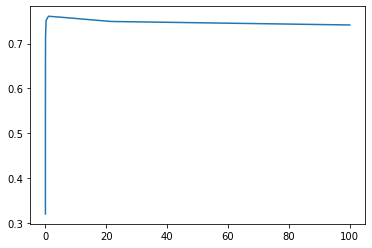

In [82]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [183]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(logit_c_values2, cv = skf, multi_class='multinomial', n_jobs=-1, random_state=17) 
logit_grid_searcher2.fit(X_train.todense(), y_train)

Wall time: 6min 22s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='multinomial', n_jobs=-1, random_state=17)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [184]:
''' ВАШ КОД ЗДЕСЬ '''
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[1].mean(axis=0)
logit_mean_cv_scores2

array([0.73481117, 0.75929815, 0.76133029, 0.76112701, 0.76133026,
       0.76133026, 0.75980615, 0.75950137, 0.75950134, 0.75929815,
       0.7588918 , 0.75858698, 0.75777422, 0.75736787, 0.75716462,
       0.7563518 , 0.75533585, 0.75513262, 0.7544214 , 0.75360851])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [185]:
''' ВАШ КОД ЗДЕСЬ '''
print(max(logit_mean_cv_scores2), logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)])
C_best = logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]

0.761330294154816 0.8263157894736842


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

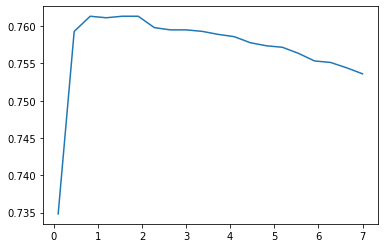

In [88]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [89]:
''' ВАШ КОД ЗДЕСЬ '''
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid.todense()))

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [90]:
''' ВАШ КОД ЗДЕСЬ '''
logit_cv_acc

0.7750651813225883

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [92]:
from sklearn.svm import LinearSVC
svm = LinearSVC(C=1, random_state=17)

In [93]:
''' ВАШ КОД ЗДЕСЬ '''
cross_val_score(svm, X_train.todense(), y_train, cv=skf).mean()

0.7509671352428245

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [94]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}
''' ВАШ КОД ЗДЕСЬ '''

svm = LinearSVC(random_state=17)

svm_grid_searcher1 = GridSearchCV(svm, svm_params1) 

svm_grid_searcher1.fit(X_train.todense(), y_train)

Wall time: 1min 21s


GridSearchCV(estimator=LinearSVC(random_state=17),
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])})

In [97]:
svm_grid_searcher1.best_params_

{'C': 4444.4445000000005}

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [98]:
''' ВАШ КОД ЗДЕСЬ '''
svm_grid_searcher1.best_params_['C']

4444.4445000000005

In [110]:
#svm_grid_searcher1.cv_results_

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

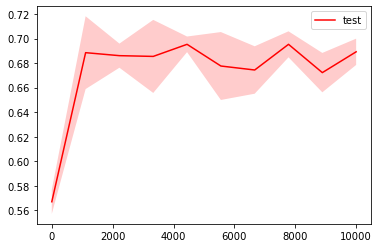

In [109]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [111]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}
''' ВАШ КОД ЗДЕСЬ '''

svm_grid_searcher2 = GridSearchCV(svm, svm_params2) 

svm_grid_searcher2.fit(X_train.todense(), y_train)

Wall time: 2min 46s


GridSearchCV(estimator=LinearSVC(random_state=17),
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])})

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [113]:
''' ВАШ КОД ЗДЕСЬ '''
svm_grid_searcher2.best_params_['C']

0.10434482758620689

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

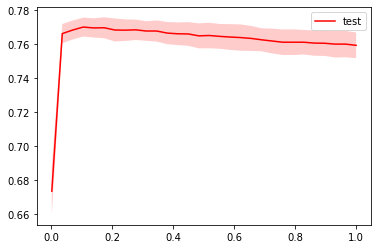

In [114]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [115]:
''' ВАШ КОД ЗДЕСЬ '''
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid.todense()))

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [122]:
''' ВАШ КОД ЗДЕСЬ '''
print(svm_grid_searcher2.best_score_, svm_cv_acc)

0.7701686093803548 0.7807537331121118


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [133]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    ''' ВАШ КОД ЗДЕСЬ '''
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y,
                                                          test_size=test_size,
                                                          random_state=random_state, 
                                                          stratify=y)
    #X_train = X_train.todense()
    #X_valid = X_valid.todense()
    
    CV_accuracy = cross_val_score(estimator, X_train, y_train, cv=cv).mean()
    accuracy = accuracy_score(y_valid, estimator.fit(X_train, y_train).predict(X_valid))
    
    return CV_accuracy, accuracy

**Убедитесь, что функция работает.**

In [124]:
cross_val_score(svm_grid_searcher2.best_estimator_, X_train.todense(), y_train, cv=skf).mean()

0.7670206386611259

In [120]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
                 os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 
                 skf, 
                 random_state=17, 
                 test_size=0.3)

(0.7659027524822642, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [125]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"cp" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [128]:
PATH_TO_DATA_2 = 'C:\\Users\\VyaznikovKS\\Desktop\\_уч\\PY_spec\\2_hypos\\capstone_user_identification'
from tqdm import tqdm

In [130]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in tqdm(itertools.product([10, 7, 5], [15, 10, 7, 5])):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA_2,'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA_2,'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        print(session_length, 
              window_size, 
              model_assessment(estimator,
                               path_to_X_pkl,
                               path_to_y_pkl,
                               skf,
                               random_state=17,
                               test_size=0.3)
             )

1it [00:03,  3.65s/it]

15 10 (0.8226990891137196, 0.8423797108319507)


2it [00:06,  3.34s/it]

10 10 (0.7670206386611259, 0.7807537331121118)


5it [00:11,  2.82s/it]

15 7 (0.8433144160027327, 0.8662684586029534)


6it [00:15,  3.16s/it]

10 7 (0.79487944166693, 0.8135058901609424)


7it [00:18,  3.20s/it]

7 7 (0.7464440727331493, 0.7585863613738179)


9it [00:25,  3.26s/it]

15 5 (0.8668835416349134, 0.8752963489805595)


10it [00:30,  3.90s/it]

10 5 (0.8142971587466218, 0.8266951161688004)


11it [00:35,  4.08s/it]

7 5 (0.7728379494871765, 0.777619724988146)


12it [00:39,  3.26s/it]

5 5 (0.7234023680828944, 0.733760075865339)
Wall time: 39.1 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [131]:
''' ВАШ КОД ЗДЕСЬ '''
#15 5 (0.8668835416349134, 0.8752963489805595)

' ВАШ КОД ЗДЕСЬ '

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [257]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in tqdm([(5,5), (7,7), (10,10)]):
    path_to_X_pkl = os.path.join(PATH_TO_DATA_2,'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA_2,'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    print(session_length,
          window_size,
          model_assessment(estimator,
                           path_to_X_pkl,
                           path_to_y_pkl,
                           skf,
                           random_state=17,
                           test_size=0.3)
         )

 33%|███████████████████████████▋                                                       | 1/3 [03:31<07:03, 211.84s/it]

5 5 (0.40764669993586033, 0.4217038983793254)


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [06:10<03:15, 195.82s/it]

7 7 (0.4349625541978715, 0.45493408727049767)


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:19<00:00, 166.43s/it]

10 10 (0.46307591254574465, 0.4836276942538802)
Wall time: 8min 19s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [135]:
''' ВАШ КОД ЗДЕСЬ '''
#10 10 (0.46307591254574465, 0.4836276942538802)

' ВАШ КОД ЗДЕСЬ '

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [251]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [179]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [186]:
import sklearn
sklearn.__version__

'0.23.1'

In [187]:
np.array([C_best, C_best])
X_train_150.shape

(95913, 27797)

In [188]:
y_train_150.shape

(95913,)

In [217]:
np.linspace(C_best, C_best, 1)

array([0.82631579])

In [218]:
%%time
logit_c_values = np.linspace(C_best, C_best, 1)
logit_cv_150users = LogisticRegressionCV(logit_c_values, cv = skf, multi_class='ovr', solver='liblinear', n_jobs=-1, random_state=17) 
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 2min 46s


LogisticRegressionCV(Cs=array([0.82631579]),
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     multi_class='ovr', n_jobs=-1, random_state=17,
                     solver='liblinear')

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [220]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()

User 1, CV score: 0.9960067978271976
User 2, CV score: 0.9963404335178755
User 3, CV score: 0.9952144130618373
User 4, CV score: 0.9917737950017204
User 5, CV score: 0.9902724343936692
User 6, CV score: 0.9944011760658097
User 7, CV score: 0.9936400696464505
User 8, CV score: 0.9858830398381867
User 9, CV score: 0.9980398903172668
User 10, CV score: 0.9952144130618373
User 11, CV score: 0.9943907499504759
User 12, CV score: 0.9936713479924514
User 13, CV score: 0.996997278783898
User 14, CV score: 0.9949120557171603
User 15, CV score: 0.9963717118638766
User 16, CV score: 0.9963404335178755
User 17, CV score: 0.9908458707370219
User 18, CV score: 0.9944324544118106
User 19, CV score: 0.9946096983724834
User 20, CV score: 0.9911899325430338
User 21, CV score: 0.9801695286353258
User 22, CV score: 0.9968825915152273
User 23, CV score: 0.9946618289491518
User 24, CV score: 0.9906582006610157
User 25, CV score: 0.9965593819398831
User 26, CV score: 0.9943177671431401
User 27, CV score: 0.9

In [222]:
#cv_scores_by_user

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [229]:
acc_diff_vs_constant = {}

class_distr = np.bincount(y_train_150.astype('int'))
sum(class_distr)

for user_id in np.unique(y_train_150):
    print(cv_scores_by_user[user_id] - (sum(class_distr) - class_distr[user_id])/sum(class_distr))
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (sum(class_distr) - class_distr[user_id])/sum(class_distr)

0.011604266366394556
0.000635993035354887
0.0008132369960276442
0.007058480080906704
0.0023250237194123446
-5.2130576668418804e-05
0.001094742110037239
0.0019705357980670524
0.0009174981493645928
0.001386673339380473
0.00023980065267481532
0.0016264739920551774
7.298280733591955e-05
5.2130576668418804e-05
2.0852230667389726e-05
0.00014596561467150604
0.0007715325346927537
0.00028150511400948375
-0.0001355394993379777
0.000750680304025475
0.003169539061441129
0.000865367572696063
0.007444246348253025
0.0006568452660223878
0.0006151408046877194
0.0006568452660222768
0.0010530376487024595
0.0037116970587929288
0.005025387590837482
0.00012511338400422733
0.0003544879213454033
0.0003023573446769845
0.0002710789986759554
0.00020852230667378624
0.0003023573446769845
0.0013032644167110252
0.001355394993379444
0.00010426115333683761
0.00014596561467161706
-5.2130576668418804e-05
0.0013345427627121653
0.0012198554940413553
3.127834600102908e-05
3.12783460011401e-05
-2.0852230667389726e-05
0.0004

In [239]:
(np.array(list(acc_diff_vs_constant.values())) > 0).sum()

134

In [231]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

134

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [244]:
''' ВАШ КОД ЗДЕСЬ '''
131/150

0.8733333333333333

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [255]:
y_binary_128 = np.array([1 if i == 128 else 0 for i in y_150users])
y_binary_128

array([0, 0, 0, ..., 0, 0, 0])

In [256]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [258]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128, train_sizes=train_sizes, cv=skf)

Wall time: 3.85 s


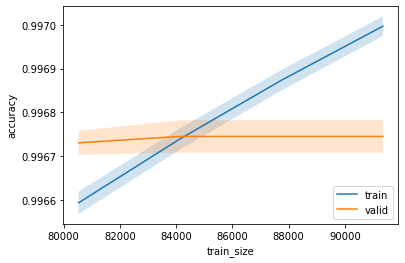

In [259]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.